# Multiple subhalos

*30 May 2024*

Populate a lens with multiple subhalos, at a realistic level.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from astropy import units as u
from astropy import constants as c

from data_gen_bright import gen_image_general
from helpers import sigma_cr, ADD

/n/home13/atsang/.local/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


## Macro convergence & area

In [3]:
pixsize = .01
pixnum = 640

In [5]:
mean_kappas = []

0


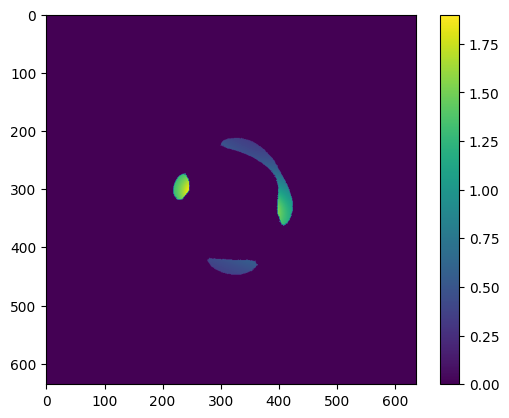

In [6]:
for seed in range(1):
    noisy, divmat, curlmat = gen_image_general(seed, True, 10.**10, 'catval',
                                               constraints={'num_exposures':10},
                                               mode='noisy div curl',
                                               cat_source=True,
                                               pixnum=pixnum, pixsize=pixsize,
                                               pixrad=4,
                                               bright_ratio=.2,
                                               n_subhalo=1)
    
    bright_area = noisy > 0.2 * np.max(noisy)
    bright_area_cropped = bright_area[2:-2,2:-2]

    print(seed)
    plt.imshow(bright_area_cropped * divmat)
    plt.colorbar()
    plt.show()
    
    mean_kappa = 0.5 * np.mean(divmat[bright_area_cropped])
    
    mean_kappas.append(mean_kappa)

In [7]:
mean_kappas

[0.3848257006069196]

In [8]:
np.mean(mean_kappas)

0.3848257006069196

In [9]:
sigma_c = sigma_cr(0.5, 1.0).to(u.Msun / u.kpc**2)

In [10]:
np.sum(bright_area)

6529

In [11]:
pixsize**2 * np.sum(bright_area) # area in arcsec^2

0.6529

In [12]:
area = pixsize**2 * np.sum(bright_area) * (np.pi/648000)**2 * (ADD(0, .5)**2).to(u.kpc**2)

In [13]:
macro_mass = (sigma_c * area).to(u.Msun).value # total macro mass in area, assuming average kappa = 1.
'%g' % macro_mass

'7.77672e+10'

And now that we have a total mass, we can calculate how many subhalos that corresponds to. What is the expected mass of a single subhalo?

In [14]:
# Calculating expected mass of a single subhalo
numerator = (10**(0.1*10) - 10**(0.1*8))/0.1
denominator =  (10**(-0.9*10) - 10**(-0.9*8))/(-0.9)
avg_mass = numerator / denominator
'%g' % (numerator / denominator)

'5.34881e+08'

In [47]:
fsub = .01 # fsub for 10^8 - 10^10 Msun
pois_l = fsub * macro_mass / avg_mass

In [48]:
pois_l

1.4539155226168865

In [49]:
# now we can calculate the number of subhalos
num_sub = np.random.poisson(pois_l)

In [50]:
num_sub

3

In [51]:
sub_masses = []
for i in range(num_sub):
    rand = np.random.rand()
    sub_mass = ((10**(-.9*10)-10**(-.9*8))*rand + 10**(-.9*8))**(-1/.9)
    sub_masses.append(sub_mass)

In [52]:
sub_masses

[151719959.83480063, 203847505.8221712, 202326580.55173564]

In [53]:
['%g' % m for m in sub_masses]

['1.5172e+08', '2.03848e+08', '2.02327e+08']

Now all that's left to do is to figure out fsub and add this as an option to gen_together.

## Conditioned poisson draws
*Can start running notebook from here.*

How to efficiently draw from a Poisson distribution, if we're not allowed to draw a zero.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
lam = .01

In [3]:
np.random.poisson(lam)

0

<BarContainer object of 20 artists>

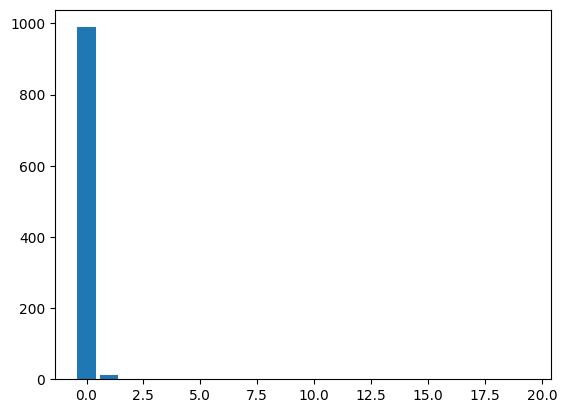

In [4]:
mycnt = Counter()
for i in range(1000):
    mycnt[np.random.poisson(lam)] += 1

cntlist = [mycnt[x] for x in range(20)]

plt.bar(range(20), cntlist)

In [5]:
def positive_poisson(lam):
    """Draws from Poisson, but have to try again if we draw a 0"""
    if lam < 10:
        def probs(k):
            """Probability of any given k if 0 is not allowed"""
            if k == 0:
                return 0
            # Otherwise, we take the regular Poisson eq, divided by 1 - its value at k=0, namely e^-lambda
            return lam**k / np.math.factorial(k) / (np.exp(lam) - 1)

        rand = np.random.rand()
        totprob = 0
        k = 0
        while True:
            k += 1
            totprob += probs(k)
            if rand < totprob:
                return k
    else: # for large lambda
        while True:
            val = np.random.poisson(lam)
            if val != 0:
                return val

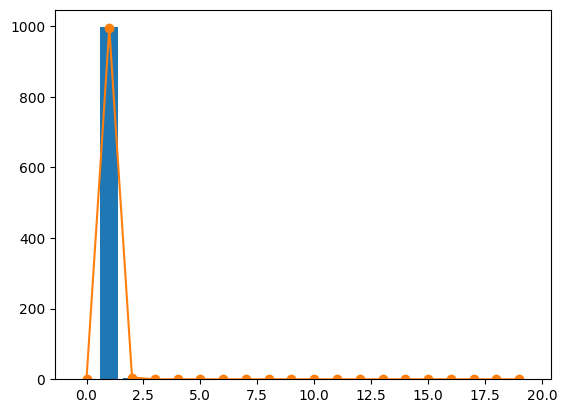

In [6]:
lam = .01
mycnt = Counter()
for i in range(1000):
    mycnt[positive_poisson(lam)] += 1

cntlist = [mycnt[x] for x in range(20)]

def probs(k):
    """Probability of any given k if 0 is not allowed"""
    if k == 0:
        return 0
    return lam**k / np.math.factorial(k) * 1 / (np.exp(lam) - 1)

plt.bar(range(20), cntlist)
plt.plot(range(20), 1000 * np.array([probs(x) for x in range(20)]), 'o-', color='C1')

## fsub as a fn of mass range

In [7]:
def total_mass(low_exp, high_exp):
    # unnormalized
    return (10**(0.1*high_exp) - 10**(0.1*low_exp)) / 0.1

def total_nr(low_exp, high_exp):
    # again, unnormalized
    return (10**(-0.9*high_exp) - 10**(-0.9*low_exp)) / (-0.9)

def avg_mass(low_exp, high_exp):
    if low_exp == high_exp:
        return 10.**low_exp
    return total_mass(low_exp, high_exp) / total_nr(low_exp, high_exp)

In [8]:
total_mass(5, 8)

31.472957846335536

In [9]:
total_mass(8, 10)

36.904265551980664

In [10]:
total_mass(8, 11)

62.79680673139741

In [11]:
total_nr(5, 8)

3.5066312074706415e-05

In [12]:
total_nr(8, 10)

6.899526049779922e-08

In [13]:
total_mass(8, 10) / total_nr(8, 10)

534881168.4413862

In [14]:
avg_mass(10, 10)

10000000000.0

## Observe test creations

In [15]:
myimg = np.load('multisubtest/000_r20_c60.npy')
myimg_nosub = np.load('multisubtest/000_r20_none.npy')

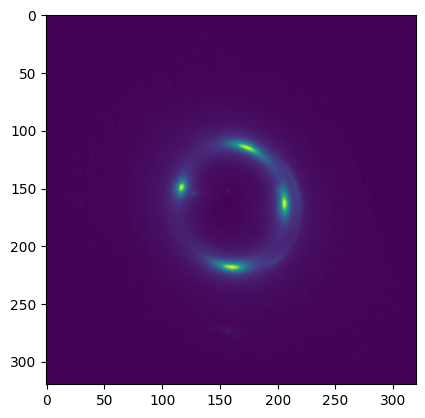

In [16]:
plt.imshow(myimg)

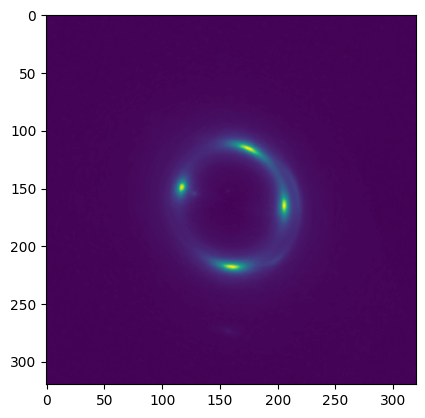

In [17]:
plt.imshow(myimg_nosub)

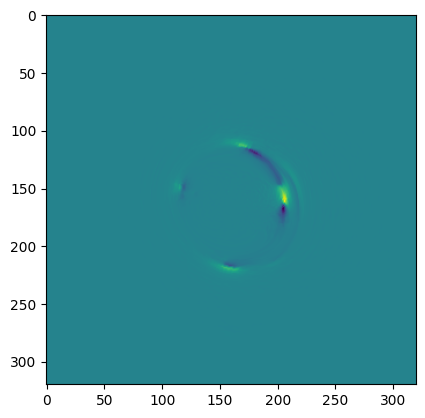

In [18]:
plt.imshow(myimg - myimg_nosub)

In [19]:
myparams = np.load('/n/holyscratch01/dvorkin_lab/Users/atsang/mif/params_catval_exp10_c20_br20_nsub1_hst/1010000.npy')

In [20]:
myparams

array([ 0.91040154,  2.01554878, -0.51099558,  0.67700594, -0.09174849,
       -0.14225042,  0.03338004,  0.0852699 ,  0.00549964,  0.81845256,
        0.00498117, -0.42579287])

## Observe scratch creations

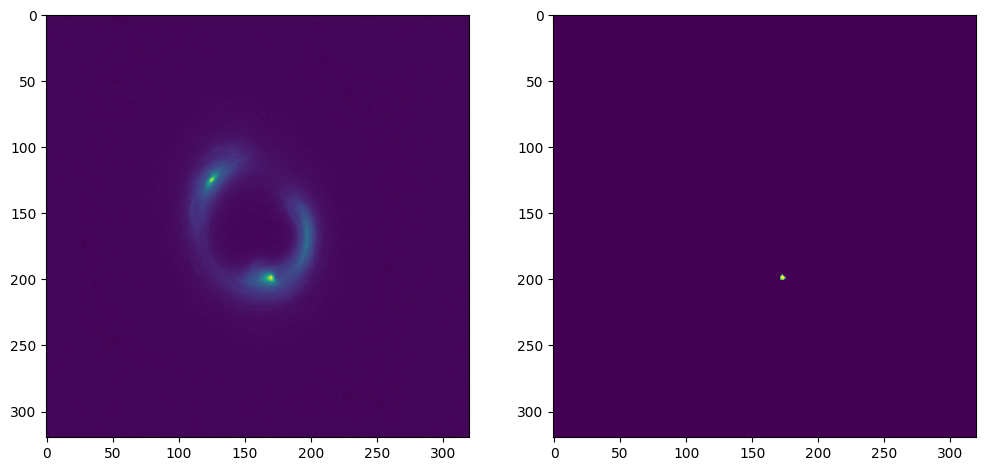

In [33]:
seed = 1010000 + 7


myimg = np.load(f'/n/holyscratch01/dvorkin_lab/Users/atsang/mif/in_catval_exp10_c60_br20_nsub-1_hstelt/{seed}.npy')
mycoord = np.load(f'/n/holyscratch01/dvorkin_lab/Users/atsang/mif/coord_catval_exp10_c60_br20_nsub-1_hstelt/{seed}.npy')

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(myimg)
ax[1].imshow(mycoord)